In [79]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [81]:
import pandas as pd

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

import torch

from torch import nn

import numpy as np

AMZN = pd.read_csv('AMZN_price_predict.csv')

AMZN["return_month"] = AMZN.price.pct_change(1, fill_method=None)

# nona has 105 records after removing NA

AMZN_nona = AMZN[['pe', 'roa', 'net_income','sales','total_debt','return_month']].dropna()

AMZN_nona[['pe', 'roa', 'net_income','sales','total_debt','return_month']] = AMZN_nona[['pe', 'roa', 'net_income','sales','total_debt','return_month']].astype(float)

In [15]:
y = AMZN_nona['return_month'].values

x = AMZN_nona[['pe', 'roa', 'net_income','sales','total_debt']].values

# seperate the dataset into training set and testing set
# should I normalize the scale first or seperate the dataset first?
# will information leak occur if I normalize the scale first? using: x = StandardScaler().fit_transform(AMZN_nona[['pe', 'roa', 'net_income','sales','total_debt']].values)
x_train = x[:80]
y_train = y[:80]
x_test = x[80:]
y_test = y[80:]


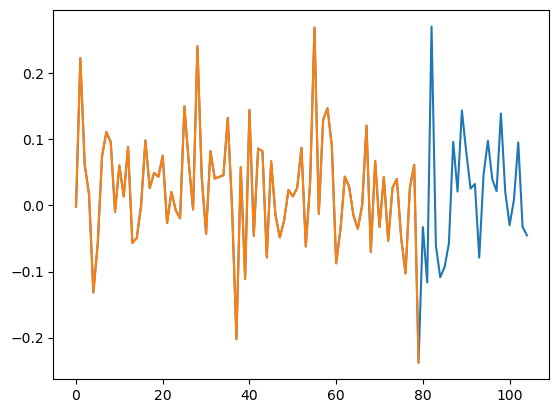

In [19]:
import matplotlib.pyplot as plt
plt.plot(y)
plt.plot(y_train)

In [20]:
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [22]:
x_columns = ['pe', 'roa', 'net_income', 'sales', 'total_debt']  
x_train_df = pd.DataFrame(x_train, columns=x_columns)
y_train_df = pd.DataFrame(y_train, columns=['return_month'])

training = pd.concat([x_train_df, y_train_df], axis=1)

print(type(training))
print(training)

<class 'pandas.core.frame.DataFrame'>
          pe       roa  net_income     sales  total_debt  return_month
0   3.813141 -1.781624   -1.106345 -1.267372   -1.155828     -0.001950
1   3.813141 -1.781624   -1.052871 -1.267372   -1.155828      0.222724
2   3.813141 -1.781624   -1.052871 -1.267372   -1.155828      0.062150
3   2.514676 -1.673325   -1.052871 -1.213288   -1.183363      0.016682
4   2.514676 -1.673325   -1.025098 -1.213288   -1.183363     -0.131516
..       ...       ...         ...       ...         ...           ...
75 -0.742319  1.410331    1.634788  1.844142    1.855252     -0.049252
76 -0.742319  1.410331    2.370669  1.844142    1.855252     -0.102830
77 -0.742319  1.410331    2.370669  1.844142    1.855252      0.026673
78 -0.562992  0.197520    2.370669  1.910934    1.779321      0.061437
79 -0.562992  0.197520    1.132180  1.910934    1.779321     -0.237525

[80 rows x 6 columns]


In [103]:
features = training[['pe', 'roa', 'net_income','sales','total_debt']].values

targets = training['return_month'].values

seq_len = 3

features = features[0:len(features)//3*3] # cut the dataset to 78 rows so that it can exactly be divided by seq_len = 3
targets = targets[0:len(features)//3*3]
print(len(features))


fea_train = []
for i in range(len(features) - seq_len + 1):  # slide one row at a time
    fea_train.append(features[i:i + seq_len])  # 3 rows in a batch

fea_train_tensor = torch.tensor(fea_train, dtype=torch.float32)


tar_train = []
for i in range(len(targets) - seq_len + 1):  
    tar_train.append(targets[i:i + seq_len])  

tar_train_tensor = torch.tensor(tar_train, dtype=torch.float32)

print(fea_train_tensor.shape) # (76, 3, 5)
print(tar_train_tensor.shape) #(76,3,1)

# want to have 76 batches, each contains 3 rows of data
# it would be (123), (234), (345) ... (76,77,78), which could be exactly divided by 3

78
torch.Size([76, 3, 5])
torch.Size([76, 3])


In [85]:
class LstmRNN(nn.Module):
    """
    LSTM Model Definition
    Parameters:
    - input_size: the number of input features
    - hidden_size: the number of hidden units in the LSTM
    - output_size: the number of outputs
    - num_layers: the number of LSTM layers to stack
    """
  
    
    def __init__(self, input_size, hidden_size = 64, output_size=1, num_layers = 1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)  # batch_first=True to match the input shape (batch_size, seq_len, input_size)
        self.linear = nn.Linear(hidden_size, output_size)  # Fully connected layer after LSTM
    
    def forward(self, x):
        x, _ = self.lstm(x)  # LSTM layer, output size (batch_size, seq_len, hidden_size)
        x = x[:, -1, :]  # Only take the output of the last time step
        x = self.linear(x)  # Fully connected layer
        return x

input_size = 5
hidden_size = 64
output_size = 1
num_layers = 1
lstm_model = LstmRNN(input_size, hidden_size, output_size=output_size, num_layers=num_layers)
print('LSTM model:', lstm_model)
print('model.parameters:', lstm_model.parameters)

LSTM model: LstmRNN(
  (lstm): LSTM(5, 64)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)
model.parameters: <bound method Module.parameters of LstmRNN(
  (lstm): LSTM(5, 64)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)>


In [86]:
loss_function = torch.nn.MSELoss()  
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-2) 

In [91]:
max_epochs = 2000

for epoch in range(max_epochs):
    lstm_model.train()  # Set the model to training mode

    # Forward pass, directly obtain the output
    output = lstm_model(fea_train_tensor)  # (batch_size, output_size)
    loss = loss_function(output, tar_train_tensor)  # Compute the loss

    # Backward pass and optimization
    optimizer.zero_grad()  # Clear the gradients
    loss.backward()  # Perform backpropagation
    optimizer.step()  # Update model parameters

    # Loss
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{max_epochs}], Loss: {loss.item():.5f}')

    # Early stopping condition
    if loss.item() < 1e-4:
        print(f'Epoch [{epoch+1}/{max_epochs}], Loss: {loss.item():.5f}, early stopping')
        break

/opt/conda/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([76, 3])) that is different to the input size (torch.Size([76, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [100/2000], Loss: 0.00513
Epoch [200/2000], Loss: 0.00465
Epoch [300/2000], Loss: 0.00458
Epoch [400/2000], Loss: 0.00479
Epoch [500/2000], Loss: 0.00449
Epoch [600/2000], Loss: 0.00449
Epoch [700/2000], Loss: 0.00449
Epoch [800/2000], Loss: 0.00449
Epoch [900/2000], Loss: 0.00449
Epoch [1000/2000], Loss: 0.00449
Epoch [1100/2000], Loss: 0.00449
Epoch [1200/2000], Loss: 0.00449
Epoch [1300/2000], Loss: 0.00449
Epoch [1400/2000], Loss: 0.00449
Epoch [1500/2000], Loss: 0.00449
Epoch [1600/2000], Loss: 0.00449
Epoch [1700/2000], Loss: 0.00449
Epoch [1800/2000], Loss: 0.00449
Epoch [1900/2000], Loss: 0.00449
Epoch [2000/2000], Loss: 0.00449


In [98]:
# use the same method to transform testing data into tensor
x_columns = ['pe', 'roa', 'net_income', 'sales', 'total_debt'] 
x_test_df = pd.DataFrame(x_test, columns=x_columns)
y_test_df = pd.DataFrame(y_test, columns=['return_month'])

testing = pd.concat([x_test_df, y_test_df], axis=1)

test_features = testing[['pe', 'roa', 'net_income', 'sales', 'total_debt']].values

In [99]:
len(test_features)

25

In [100]:
# testing set
seq_len = 3
test_features = test_features[0:len(test_features)//3*3]

print(len(test_features))

24


In [102]:
fea_test = []
for i in range(len(test_features) - seq_len + 1):  
    fea_test.append(test_features[i:i + seq_len]) 

fea_test_tensor = torch.tensor(fea_test, dtype=torch.float32)

print(fea_test_tensor.shape)

torch.Size([22, 3, 5])


In [104]:
lstm_model.eval()

LstmRNN(
  (lstm): LSTM(5, 64)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

In [105]:
# to predict
with torch.no_grad():  
    predicted_test_y = lstm_model(fea_test_tensor)  

In [106]:
predicted_test_y

tensor([[ 0.1148],
        [ 0.3343],
        [ 0.4084],
        [ 0.4295],
        [ 0.3951],
        [ 0.5760],
        [ 0.5036],
        [ 0.4939],
        [ 0.4497],
        [ 0.3656],
        [ 0.3806],
        [ 0.3130],
        [ 0.2364],
        [ 0.2227],
        [ 0.1203],
        [-0.0341],
        [-0.0962],
        [-0.0802],
        [-0.0904],
        [-0.1051],
        [-0.1256],
        [-0.1258]])

In [107]:
predicted_test_y = predicted_test_y.view(-1).data.numpy()

print("Predicted return_month for testing set:", predicted_test_y)

Predicted return_month for testing set: [ 0.11484162  0.3343026   0.40844345  0.4294602   0.3950751   0.57598054
  0.50359666  0.49394247  0.44969353  0.36563012  0.38061264  0.3130227
  0.23636171  0.22274578  0.12034813 -0.03409179 -0.096155   -0.08019047
 -0.09039908 -0.10505662 -0.12558958 -0.12581193]


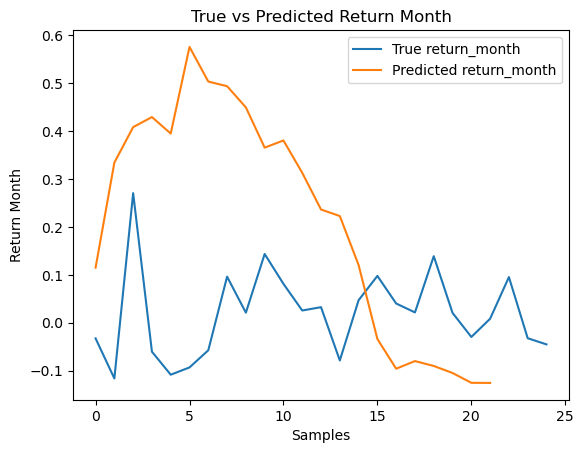

In [108]:
import matplotlib.pyplot as plt

plt.plot(y_test, label='True return_month')
plt.plot(predicted_test_y, label='Predicted return_month')
plt.xlabel('Samples')
plt.ylabel('Return Month')
plt.legend()
plt.title('True vs Predicted Return Month')
plt.show()